In [36]:
%reload_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm
import h5py
import numpy as np

sys.path.append("..")
import axionmirror.units_constants as uc

from config import pc_dict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## 1. Reach

### 1. CHIME

In [6]:
pc = pc_dict['CHIME']

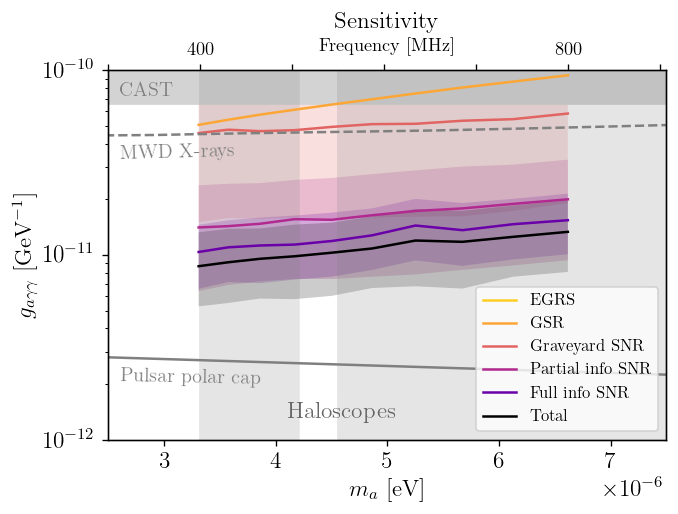

In [31]:
plot_names = ['egrs', 'gsr', 'snrg', 'snrp', 'snrf', 'total']
plot_all_samples = False

label_dict = {
    'egrs' : 'EGRS',
    'gsr' : 'GSR',
    'snrg' : 'Graveyard SNR',
    'snrp' : 'Partial info SNR',
    'snrfp' : 'Catalogue SNR',
    'snrf' : 'Full info SNR',
    'total' : 'Total',
}
color_dict = {
    'egrs' : cms['plasma'](0.9),
    'gsr' : cms['plasma'](0.8),
    'snrg' : cms['plasma'](0.6),
    'snrp' : cms['plasma'](0.4),
    'snrfp' : cms['plasma'](0.3),
    'snrf' : cms['plasma'](0.2),
    'total' : 'k',
}

fig, ax = plt.subplots()

for pn in plot_names:
    with h5py.File(f"../outputs/plot_data/{pc.name}/{pn}.h5", 'r') as hf:
        # nu_arr = np.delete(hf['nu'][:], 18, axis=0)
        # gagg_arr = np.delete(hf['gagg'][:], 18, axis=1)
        nu_arr = hf['nu'][:]
        gagg_arr = hf['gagg'][:]
        
        ma_arr = 4 * np.pi * uc.hbar * nu_arr / uc.eV
        
        if gagg_arr.shape[0] == 1:
            ax.plot(ma_arr, gagg_arr[0], color=color_dict[pn], label=label_dict[pn])
        else:
            if plot_all_samples:
                for i, gagg_sample in enumerate(gagg_arr):
                    ax.plot(ma_arr, gagg_sample, color=color_dict[pn], alpha=0.1,
                            label=(label_dict[pn] if i==0 else None), zorder=-1)
            else:
                ax.plot(ma_arr, np.median(gagg_arr, axis=0), color=color_dict[pn], label=label_dict[pn])
                ax.fill_between(ma_arr, np.quantile(gagg_arr, 0.95, axis=0), np.quantile(gagg_arr, 0.05, axis=0),
                                alpha=0.2, facecolor=color_dict[pn], edgecolor='none')

ax.fill_between([1e-6, 1e-5], uc.gagg_CAST/uc.invGeV, 1e-8, color='lightgray')
ax.text(2.6e-6, 7.3e-11, 'CAST', color='gray')
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/PulsarPolarCap.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='-')
ax.text(2.6e-6, 2e-12, 'Pulsar polar cap', color='gray', rotation=-1.2)
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/MWDXrays.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='--')
ax.text(2.6e-6, 3.3e-11, 'MWD X-rays', color='gray', rotation=1.5)
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/ADMX2021.txt", unpack=True)
ax.fill_between(limit_ma_arr, limit_gagg_arr, np.full_like(limit_gagg_arr, 1), color='gray', alpha=0.2, ec=None)
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/RBF_UF_Haloscopes.txt", unpack=True)
ax.fill_between(limit_ma_arr, limit_gagg_arr, np.full_like(limit_gagg_arr, 1), color='gray', alpha=0.2, ec=None)
ax.text(4.1e-6, 1.3e-12, 'Haloscopes', color=cms['binary'](0.6), fontsize=14)

ax.set(xlim=(2.5e-6, 7.5e-6), ylim=(1e-12, 1e-10), yscale='log')
ax.set(xlabel='$m_a$ [eV]', ylabel=r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', title='Sensitivity')

ax_top = ax.twiny()
ax_top.set_xlim(np.array(ax.get_xlim()) * uc.eV / (4*np.pi*uc.hbar))
ax_top.set_xlabel('Frequency [MHz]', fontsize=11)
ax_top.set_xticks([300, 400, 500, 600, 700, 800, 900])
ax_top.set_xticklabels(['', '400', '', '', '', '800', ''], fontsize=11)
ax_top.xaxis.set_label_coords(0.5, 1.05)

ax.legend(loc='lower right', fontsize=10)
fig.savefig('../outputs/reach_plots/CHIME.pdf')

### 1.2 Different telescopes

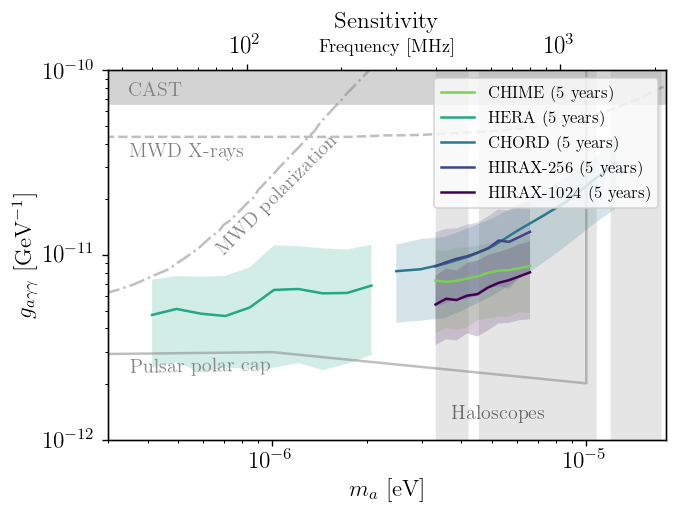

In [77]:
from config import pc_dict
pc_names = ['CHIME', 'HERA', 'CHORD', 'HIRAX256', 'HIRAX1024']
plot_all_samples = False

label_dict = {
    'CHIME' : 'CHIME (5 years)',
    'HERA' : 'HERA (5 years)',
    'CHORD' : 'CHORD (5 years)',
    'HIRAX256' : 'HIRAX-256 (5 years)',
    'HIRAX1024' : 'HIRAX-1024 (5 years)',
}
color_dict = {
    'CHIME' : cms['viridis'](0.8),
    'HERA' : cms['viridis'](0.6),
    'CHORD' : cms['viridis'](0.4),
    'HIRAX256' : cms['viridis'](0.2),
    'HIRAX1024' : cms['viridis'](0.0),
}

fig, ax = plt.subplots()

for pc_name in pc_names:

    pc = pc_dict[pc_name]

    with h5py.File(f"../outputs/plot_data/{pc.name}/total.h5", 'r') as hf:
        nu_arr = np.array(hf['nu'][:])
        gagg_arr = np.array(hf['gagg'][:])
        
        ma_arr = 4 * np.pi * uc.hbar * nu_arr / uc.eV
        color = color_dict[pc_name]
        label = label_dict[pc_name]
        
        if gagg_arr.shape[0] == 1:
            ax.plot(ma_arr, gagg_arr[0], color=color, label=label_dict[pc_name])
        else:
            if plot_all_samples:
                for i, gagg_sample in enumerate(gagg_arr):
                    ax.plot(ma_arr, gagg_sample, color=color, alpha=0.1,
                            label=(label if i==0 else None), zorder=-1)
            else:
                ax.plot(ma_arr, np.median(gagg_arr, axis=0), color=color, label=label)
                ax.fill_between(ma_arr, np.quantile(gagg_arr, 0.95, axis=0), np.quantile(gagg_arr, 0.05, axis=0),
                                alpha=0.2, facecolor=color, edgecolor='none')

ax.fill_between([1e-8, 1e-4], uc.gagg_CAST/uc.invGeV, 1e-8, color='lightgray')
ax.text(3.5e-7, 7.3e-11, 'CAST', color='gray')
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/PulsarPolarCap.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='-', alpha=0.5)
ax.text(3.5e-7, 2.3e-12, 'Pulsar polar cap', color='gray', rotation=1)
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/MWDPolarisation.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='-.', alpha=0.5)
ax.text(6.5e-7, 1e-11, 'MWD polarization', color='gray', rotation=45)
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/MWDXrays.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='--', alpha=0.5)
ax.text(3.5e-7, 3.4e-11, 'MWD X-rays', color='gray')
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/ADMX2021.txt", unpack=True)
ax.fill_between(limit_ma_arr, limit_gagg_arr, np.full_like(limit_gagg_arr, 1), color='gray', alpha=0.2, ec=None)
limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/RBF_UF_Haloscopes.txt", unpack=True)
ax.fill_between(limit_ma_arr, limit_gagg_arr, np.full_like(limit_gagg_arr, 1), color='gray', alpha=0.2, ec=None)
ax.text(3.7e-6, 1.3e-12, 'Haloscopes', color=cms['binary'](0.6))

ax.set(yscale='log', xscale='log')
ax.set(xlim=(3e-7, 1.8e-5), ylim=(1e-12, 1e-10))
ax.set(xlabel='$m_a$ [eV]', ylabel=r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', title='Sensitivity')

ax_top = ax.twiny()
ax_top.set(xscale=ax.get_xscale())
ax_top.set_xlim(np.array(ax.get_xlim()) * uc.eV / (4 * np.pi * uc.hbar))
ax_top.set_xlabel('Frequency [MHz]', fontsize=11)
ax_top.xaxis.set_label_coords(0.5, 1.05)

ax.legend(loc='upper right', fontsize=10)
fig.savefig('../outputs/reach_plots/all.pdf')

## 2. Graveyard samples

In [38]:
from config import wdir

In [39]:
zs = np.load(f'{wdir}/CHIME-nnu10-nra1-ndec1/snr-graveyard/snr-graveyard-inu6-ira0-idec0.npy')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:04<00:00,  7.43it/s]


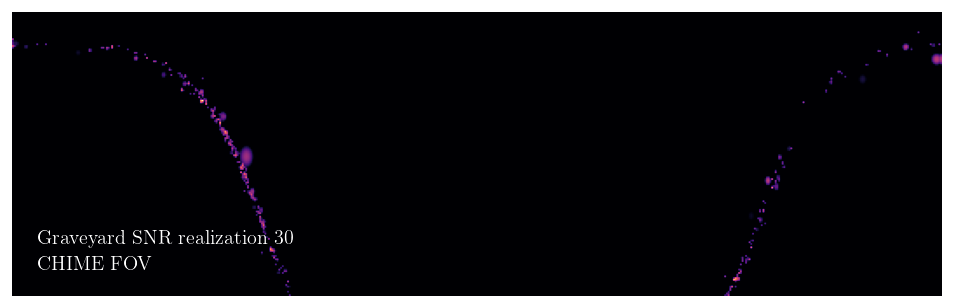

In [52]:
n_show = 30

for i in tqdm(range(n_show)):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(np.flipud(np.log10(np.clip(zs[i], 1e-9, None))),
              extent=(180, -180, -20, 90), vmin=-9, vmax=-4, cmap='magma')
    ax.axis('off')
    ax.text(170, -0, f'Graveyard SNR realization {i+1}', color='white', fontsize=12)
    ax.text(170, -10, 'CHIME FOV', color='white', fontsize=12)
    fig.savefig(f"../outputs/plot_graveyard_samples/{i}.png", pad_inches=0.)
    if i != n_show-1:
        plt.close()

In [53]:
from PIL import Image

def create_gif_from_pngs(png_dir, n_png, output_path):
    images = []
    for i in range(n_png):
        image = Image.open(f'{png_dir}/{i}.png')
        images.append(image)
    images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

create_gif_from_pngs('../outputs/plot_graveyard_samples', n_show, '../outputs/graveyard_samples.gif')

## 3. Check pixelization

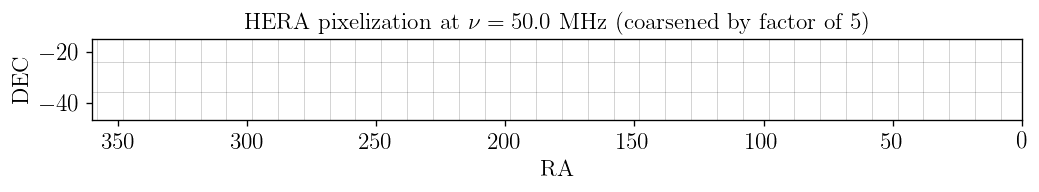

In [76]:
pc = pc_dict['HERA']
pc.build(0, 0, 0)

fig, ax = plt.subplots(figsize=(10, 5))
for dec in pc.dec_edges[::5]:
    ax.axhline(np.rad2deg(dec), color='k', alpha=0.2, linewidth=0.5)
for ra in pc.ra_edges[::5]:
    ax.axvline(np.rad2deg(ra), color='k', alpha=0.2, linewidth=0.5)
ax.set(xlim=(360, 0), ylim=(np.rad2deg(pc.telescope.survey_dec_min(pc.nu)), np.rad2deg(pc.telescope.survey_dec_max(pc.nu))), aspect=1)
ax.set(xlabel='RA', ylabel='DEC', title=pc.telescope.name + rf' pixelization at $\nu={pc.nu:.1f}$~MHz (coarsened by factor of 5)')
fig.savefig(f'../outputs/{pc.telescope.name}_pixels.pdf', bbox_inches='tight')

## A3. Check new pixelization

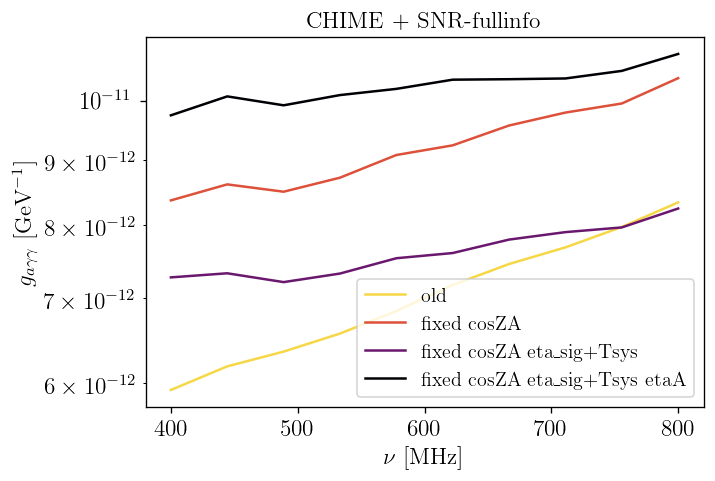

In [3]:
fig, ax = plt.subplots()

with h5py.File(f"../outputs/plot_data/CHIME-10-4-4/snrf0.h5", 'r') as hf:
    nu0 = hf['nu'][:]
    gagg0 = hf['gagg'][:][0]
    ax.plot(nu0, gagg0, color=cms['inferno'](0.9), label='old')
with h5py.File(f"../outputs/plot_data/CHIME-10-4-4/snrf1.h5", 'r') as hf:
    nu0 = hf['nu'][:]
    gagg0 = hf['gagg'][:][0]
    ax.plot(nu0, gagg0, color=cms['inferno'](0.6), label='fixed cosZA')
with h5py.File(f"../outputs/plot_data/CHIME-10-4-4/snrf2.h5", 'r') as hf:
    nu0 = hf['nu'][:]
    gagg0 = hf['gagg'][:][0]
    ax.plot(nu0, gagg0, color=cms['inferno'](0.3), label='fixed cosZA eta_sig+Tsys')
with h5py.File(f"../outputs/plot_data/CHIME-10-4-4/snrf3.h5", 'r') as hf:
    nu0 = hf['nu'][:]
    gagg0 = hf['gagg'][:][0]
    ax.plot(nu0, gagg0, color=cms['inferno'](0.0), label='fixed cosZA eta_sig+Tsys etaA')
ax.set(yscale='log')
ax.set(xlabel=r'$\nu$ [MHz]', ylabel=r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]',
       title='CHIME + SNR-fullinfo')
ax.legend();

## A2. Extragalactic radio sources

In [8]:
gagg1

array([6.18759602e-11, 5.39990655e-11, 7.49198254e-11, 7.08917018e-11,
       6.47874184e-11, 5.82142573e-11, 7.94846051e-11, 7.48339958e-11,
       6.98201607e-11, 6.19006962e-11, 8.43371752e-11, 7.91967499e-11,
       7.41122218e-11, 6.59924765e-11, 8.96632719e-11, 8.49073752e-11,
       7.87497170e-11, 7.02039923e-11, 9.59028045e-11, 9.01232557e-11,
       8.35985970e-11, 7.45362189e-11, 1.00743185e-10, 9.54320606e-11,
       8.85885936e-11, 7.97624384e-11, 1.06496398e-10, 1.00705740e-10,
       9.36327045e-11, 8.42833120e-11])

[None]

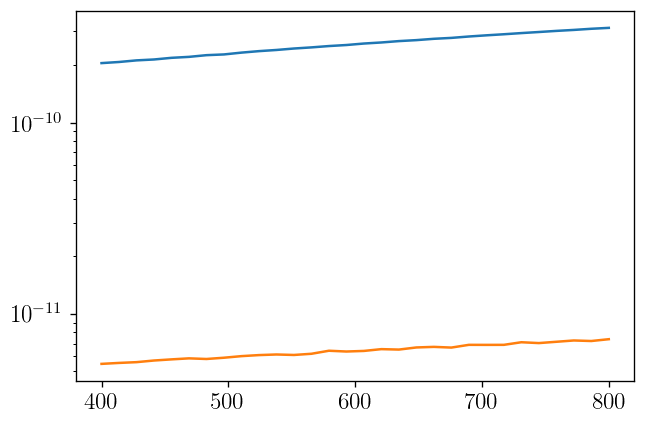

In [14]:
fig, ax = plt.subplots()

with h5py.File(f"../outputs/plot_data/CHIME-nnu30-nra3-ndec3/egrs.h5", 'r') as hf:
    nu0 = hf['nu'][:]
    gagg0 = hf['gagg'][:][0]
    ax.plot(nu0, gagg0, color='C0')
with h5py.File(f"../outputs/plot_data/CHIME-nnu30-nra3-ndec3/total.h5", 'r') as hf:
    nu1 = hf['nu'][:]
    gagg1 = hf['gagg'][:][0]
    ax.plot(nu1, gagg1, color='C1')
ax.set(yscale='log')

## A1. Check gsr old v new

In [15]:
config_name = 'CHIME-nnu30-nra3-ndec3'
config = config_dict[config_name]

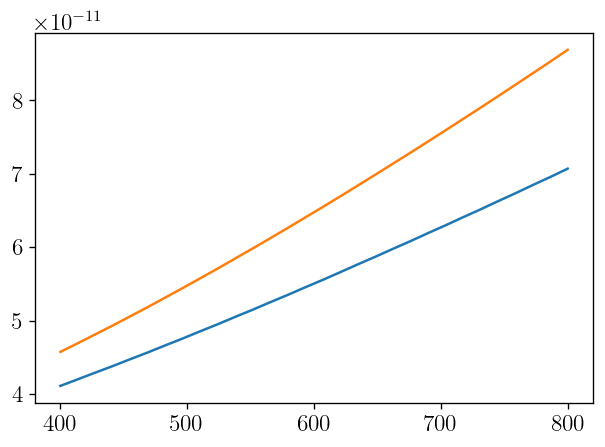

In [16]:
fig, ax = plt.subplots()

with h5py.File(f"../outputs/plot_data/{config_name}/gsr.h5", 'r') as hf:
    nu0 = hf['nu'][:]
    gagg0 = hf['gagg'][:][0]
    ax.plot(nu0, gagg0, color='C0')
with h5py.File(f"../outputs/plot_data/{config_name}/gsr.old.h5", 'r') as hf:
    nu1 = hf['nu'][:]
    gagg1 = hf['gagg'][:][0]
    ax.plot(nu1, gagg1, color='C1')

In [17]:
gagg0/gagg1

array([0.89883146, 0.89527977, 0.8917363 , 0.88795032, 0.88450648,
       0.88081036, 0.87744507, 0.87381254, 0.87057528, 0.86711107,
       0.86393137, 0.86059297, 0.85763686, 0.85438066, 0.85149524,
       0.84841363, 0.84570208, 0.84301248, 0.84004066, 0.83751029,
       0.83471127, 0.83230365, 0.82962335, 0.82729255, 0.82477908,
       0.8225971 , 0.82012357, 0.81805029, 0.81573346, 0.81376627])

In [6]:
with h5py.File(f"../outputs/gsr/Ta_408MHz_fieldJF.h5") as hf:
    Ta = hf['Ta'][:]

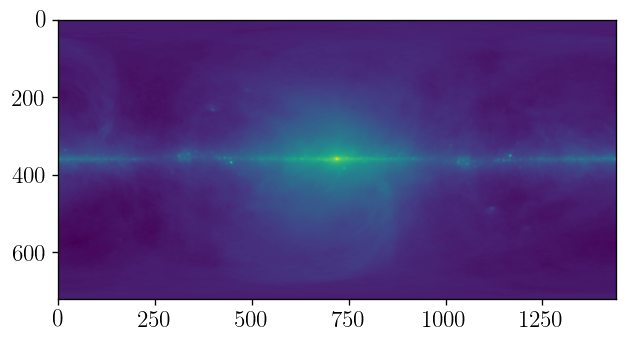

In [7]:
plt.imshow(np.log(Ta))

In [8]:
np.mean(Ta)

5.32123e-07

In [18]:
prefix = '/n/holyscratch01/iaifi_lab/yitians/all_sky_gegenschein/axions-against-the-world/outputs/intermediates/CHIME-nnu30-nra3-ndec3'
z0 = np.load(f'{prefix}/gsr_JF/gsr-inu0-ira1-idec2.npy')
z1 = np.load(f'{prefix}/gsr_JF_old/gsr-inu0-ira1-idec2.npy')

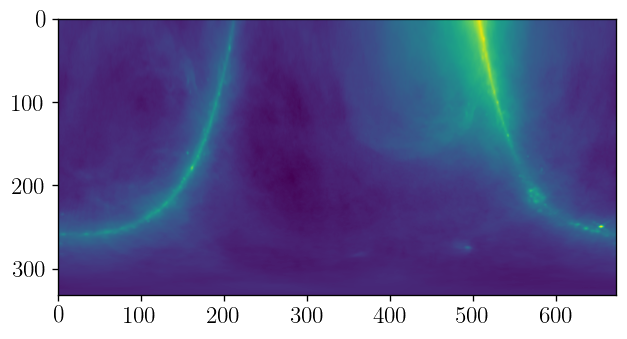

In [22]:
plt.imshow(np.log(z0))

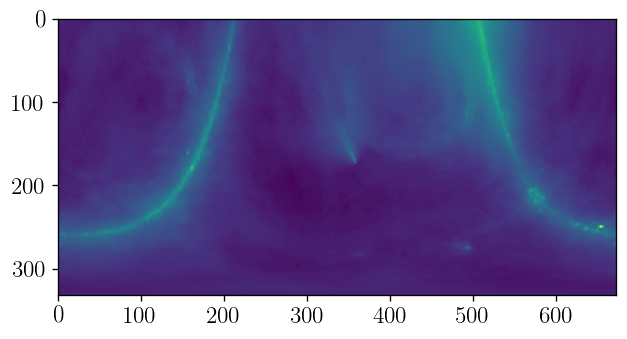

In [23]:
plt.imshow(np.log(z1))

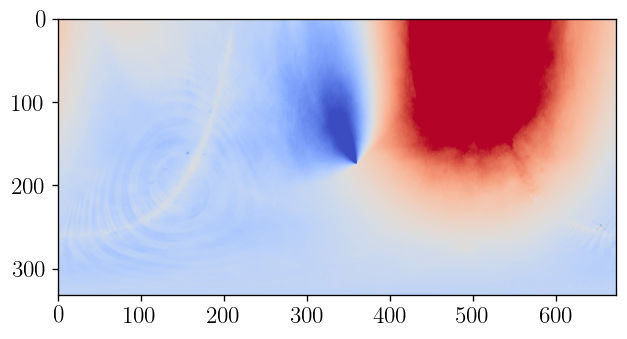

In [21]:
plt.imshow(z0/z1, vmin=0.5, vmax=1.5, cmap='coolwarm')

In [24]:
np.mean(z0)

5.2147897e-07

In [25]:
np.mean(z1)

4.299195e-07

In [26]:
np.mean(z0/z1)

1.052278

## TMP